In [2]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data tables
student_info = pd.read_csv("studentInfo.csv")
student_vle = pd.read_csv("studentVle.csv")
assessments = pd.read_csv("studentAssessment.csv")
courses = pd.read_csv("courses.csv")

In [4]:
# Aggregate VLE interactions per student
vle_agg = student_vle.groupby('id_student')['sum_click'].sum().reset_index()
vle_agg.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

In [5]:
# Aggregate assessment performance per student
assessments_agg = assessments.groupby('id_student').agg({
    'score': 'mean',
    'id_assessment': 'count'
}).reset_index()
assessments_agg.rename(columns={
    'score': 'avg_score',
    'id_assessment': 'total_assessments'
}, inplace=True)

In [6]:
# Merge datasets
df = student_info.merge(vle_agg, on='id_student', how='left')
df = df.merge(assessments_agg, on='id_student', how='left')
df = df.merge(courses, on=['code_module', 'code_presentation'], how='left')

In [7]:
df.isnull().sum()

code_module                      0
code_presentation                0
id_student                       0
gender                           0
region                           0
highest_education                0
imd_band                      1111
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
total_clicks                  2852
avg_score                     5866
total_assessments             5847
module_presentation_length       0
dtype: int64

In [8]:
# Handle missing values
df.fillna(0, inplace=True)

In [9]:
# Define target column (1 = Withdrawn, 0 = others)
df['target'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  int64  
 3   gender                      32593 non-null  object 
 4   region                      32593 non-null  object 
 5   highest_education           32593 non-null  object 
 6   imd_band                    32593 non-null  object 
 7   age_band                    32593 non-null  object 
 8   num_of_prev_attempts        32593 non-null  int64  
 9   studied_credits             32593 non-null  int64  
 10  disability                  32593 non-null  object 
 11  final_result                32593 non-null  object 
 12  total_clicks                32593 non-null  float64
 13  avg_score                   325

In [11]:
for col in df.columns:
    types = df[col].apply(type).nunique()
    if types > 1:
        print(f"⚠️ Column '{col}' has mixed types.")

⚠️ Column 'imd_band' has mixed types.


In [12]:
# Convert imd-band to string
df['imd_band'] = df['imd_band'].astype(str).fillna('Unknown')

In [13]:
# One-Hot Encode 'region'
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)

# Label Encode other categorical columns
label_cols = ['gender', 'highest_education', 'imd_band', 'age_band', 'disability']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [14]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
0,AAA,2013J,11391,1,East Anglian Region,1,9,2,0,240,...,False,False,False,False,False,False,False,False,False,False
1,AAA,2013J,28400,0,Scotland,1,2,1,0,60,...,False,False,False,True,False,False,False,False,False,False
2,AAA,2013J,30268,0,North Western Region,0,3,1,0,60,...,False,False,True,False,False,False,False,False,False,False
3,AAA,2013J,31604,0,South East Region,0,5,1,0,60,...,False,False,False,False,True,False,False,False,False,False
4,AAA,2013J,32885,0,West Midlands Region,2,5,0,0,60,...,False,False,False,False,False,False,False,False,True,False


In [15]:
# Normalize numerical columns
scaler = StandardScaler()
num_cols = ['num_of_prev_attempts', 'studied_credits', 'total_clicks', 'avg_score', 'total_assessments']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [16]:
# Keeping only one row per student
df = df.drop_duplicates(subset='id_student')

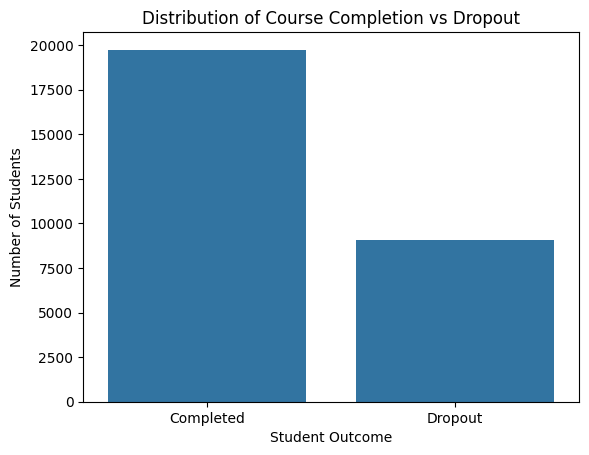

In [17]:
# Class Distribution (Dropout vs. Completed)
sns.countplot(data=df, x='target')
plt.title('Distribution of Course Completion vs Dropout')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Number of Students')
plt.show()

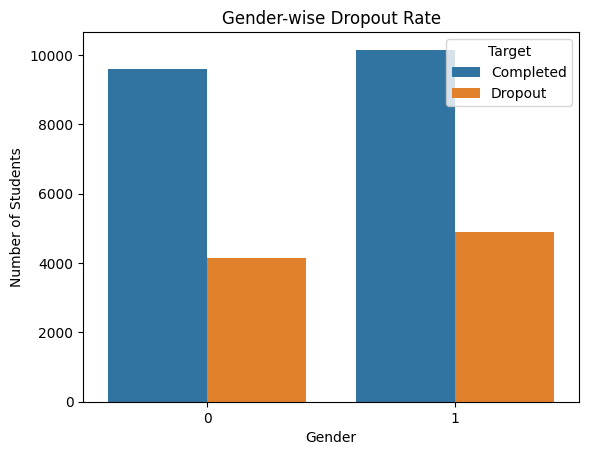

In [18]:
#Gender vs. Dropout Rate
sns.countplot(data=df, x='gender', hue='target')
plt.title('Gender-wise Dropout Rate')
plt.xlabel('Gender')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

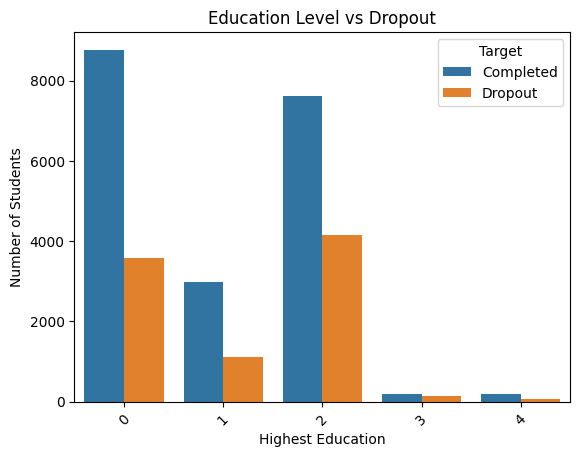

In [19]:
#Education Level vs Dropout
sns.countplot(data=df, x='highest_education', hue='target')
plt.title('Education Level vs Dropout')
plt.xticks(rotation=45)
plt.xlabel('Highest Education')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

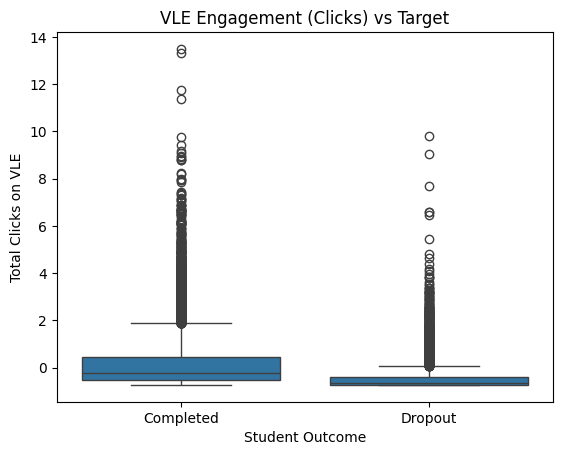

In [20]:
# Total Clicks vs Dropout
sns.boxplot(data=df, x='target', y='total_clicks')
plt.title('VLE Engagement (Clicks) vs Target')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Total Clicks on VLE')
plt.show()

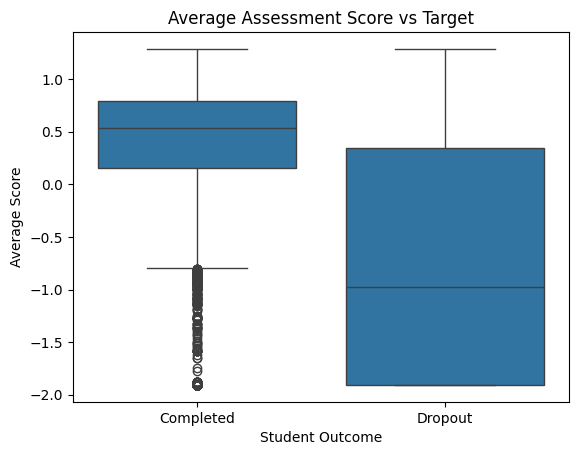

In [21]:
#  Avg Score vs Dropout
sns.boxplot(data=df, x='target', y='avg_score')
plt.title('Average Assessment Score vs Target')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Average Score')
plt.show()

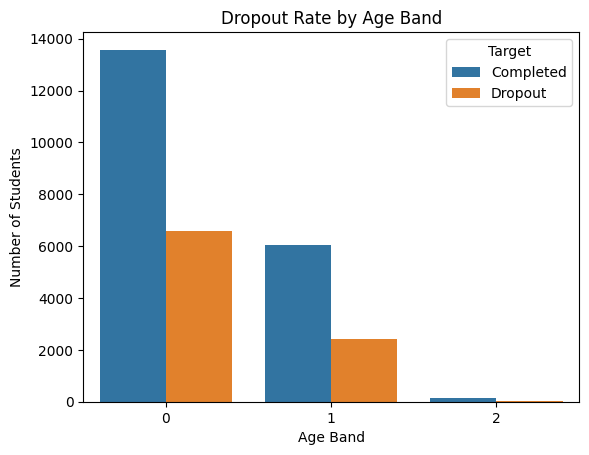

In [22]:
# Age Band vs Dropout
sns.countplot(data=df, x='age_band', hue='target')
plt.title('Dropout Rate by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

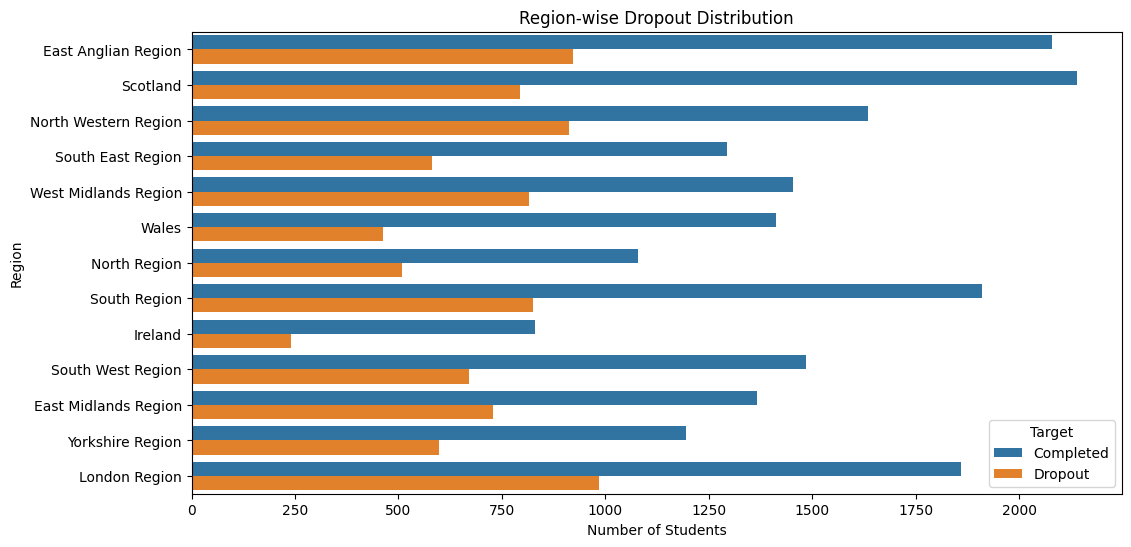

In [23]:
# Region-wise Dropouts
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='region', hue='target')
plt.title('Region-wise Dropout Distribution')
plt.xlabel('Number of Students')
plt.ylabel('Region')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

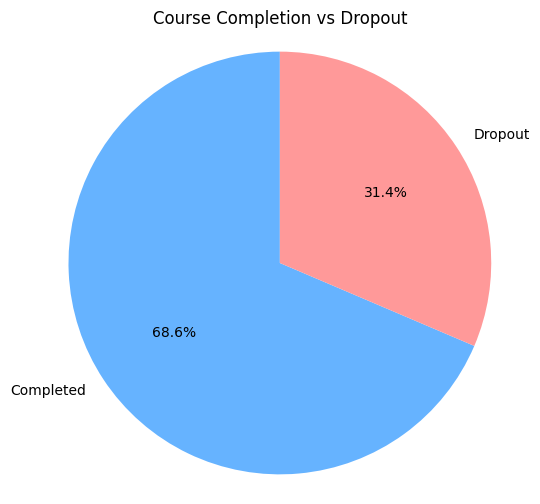

In [24]:
# Dropout vs Completed
labels = ['Completed', 'Dropout']
sizes = df['target'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Course Completion vs Dropout')
plt.axis('equal')
plt.show()

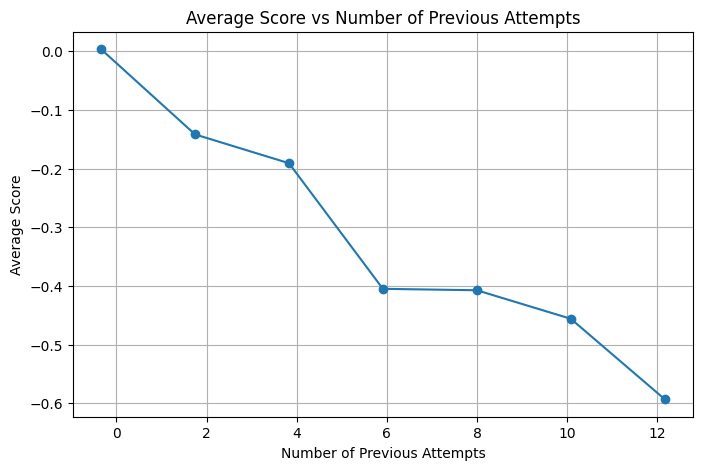

In [25]:
# Average Score vs Number of Previous Attempts
avg_score_by_attempts = df.groupby('num_of_prev_attempts')['avg_score'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(avg_score_by_attempts['num_of_prev_attempts'], avg_score_by_attempts['avg_score'], marker='o')
plt.title('Average Score vs Number of Previous Attempts')
plt.xlabel('Number of Previous Attempts')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

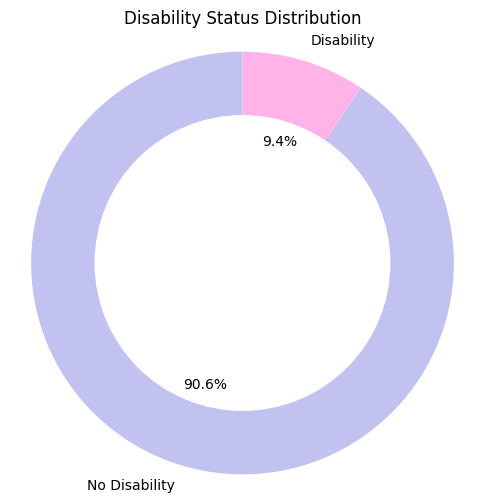

In [26]:
#  Disability Status
disability_counts = df['disability'].value_counts()
labels = ['No Disability', 'Disability']
plt.figure(figsize=(6,6))
plt.pie(disability_counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=['#c2c2f0','#ffb3e6'])
plt.title('Disability Status Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()

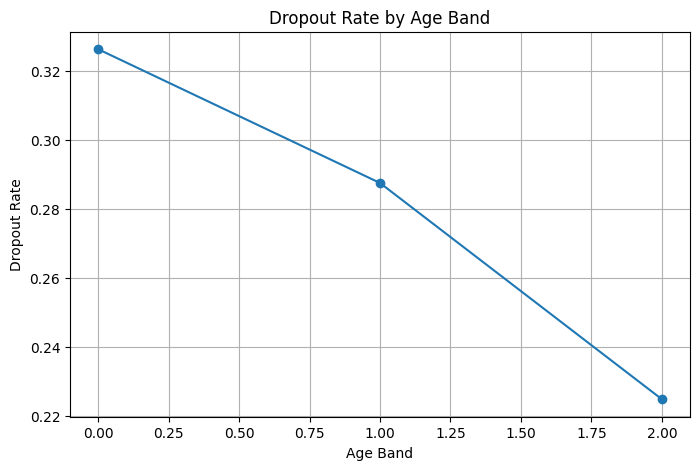

In [27]:
#  Dropout Rate by Age Band
age_dropout = df.groupby('age_band')['target'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(age_dropout['age_band'], age_dropout['target'], marker='o')
plt.title('Dropout Rate by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Dropout Rate')
plt.grid(True)
plt.show()

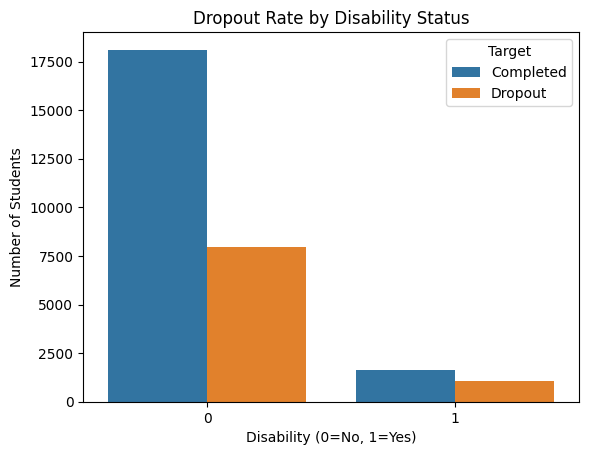

In [28]:
# Disability vs Dropout Rate
sns.countplot(data=df, x='disability', hue='target')
plt.title('Dropout Rate by Disability Status')
plt.xlabel('Disability (0=No, 1=Yes)')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

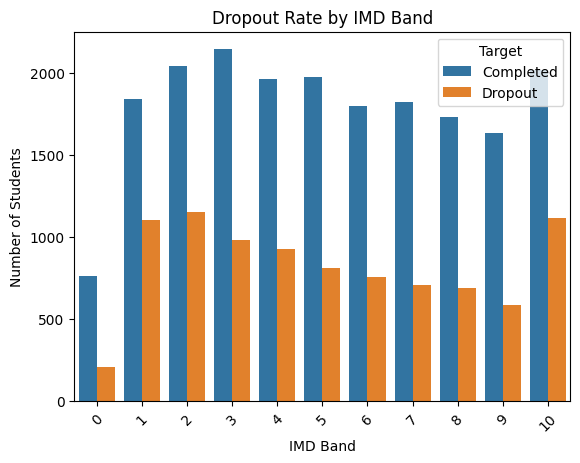

In [29]:
# IMD Band vs Dropout
sns.countplot(data=df, x='imd_band', hue='target')
plt.title('Dropout Rate by IMD Band')
plt.xlabel('IMD Band')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.xticks(rotation=45)
plt.show()

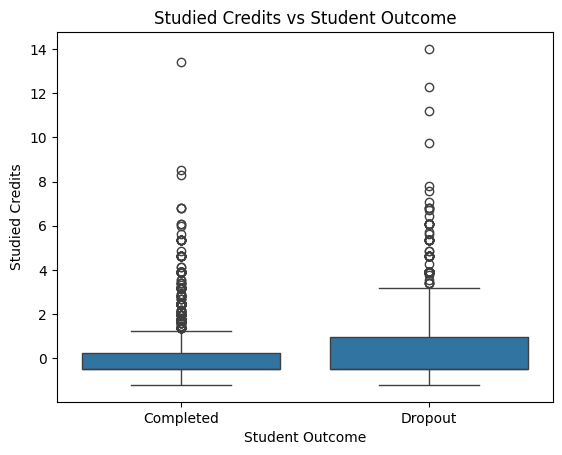

In [30]:
# Studied Credits vs Dropout
sns.boxplot(data=df, x='target', y='studied_credits')
plt.title('Studied Credits vs Student Outcome')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Studied Credits')
plt.show()

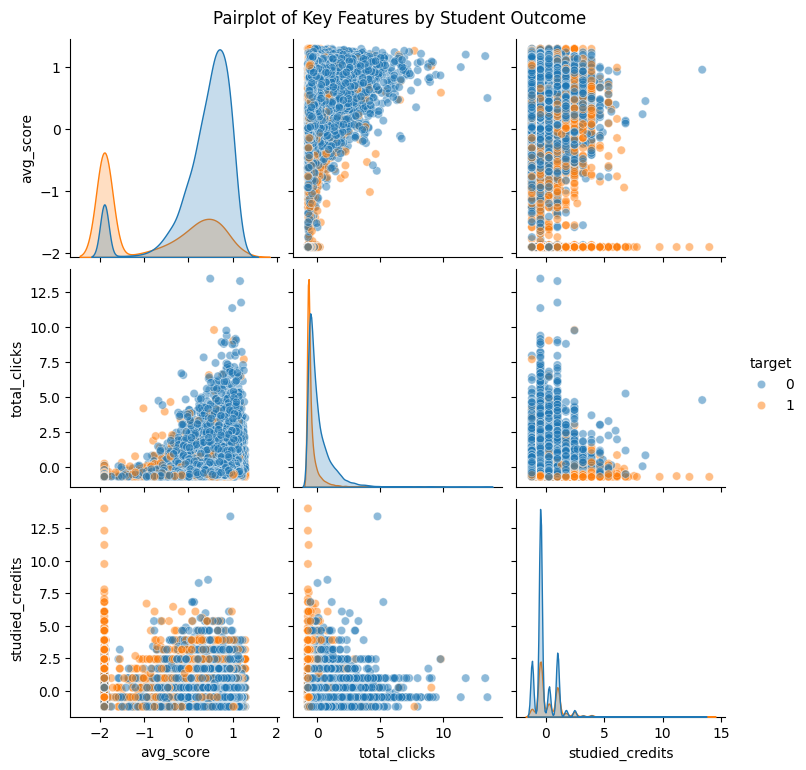

In [31]:
# Pairplot for selected features
sns.pairplot(df, vars=['avg_score', 'total_clicks', 'studied_credits'], hue='target', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot of Key Features by Student Outcome', y=1.02)
plt.show()

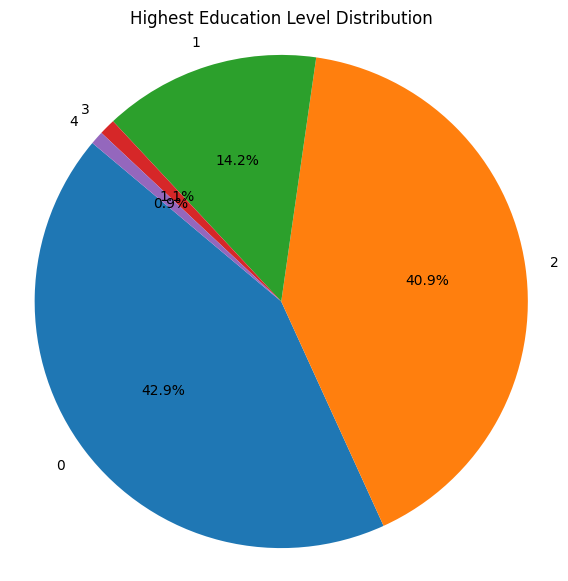

In [32]:
#  Highest Education Level
edu_counts = df['highest_education'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(edu_counts, labels=edu_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Highest Education Level Distribution')
plt.axis('equal')
plt.show()

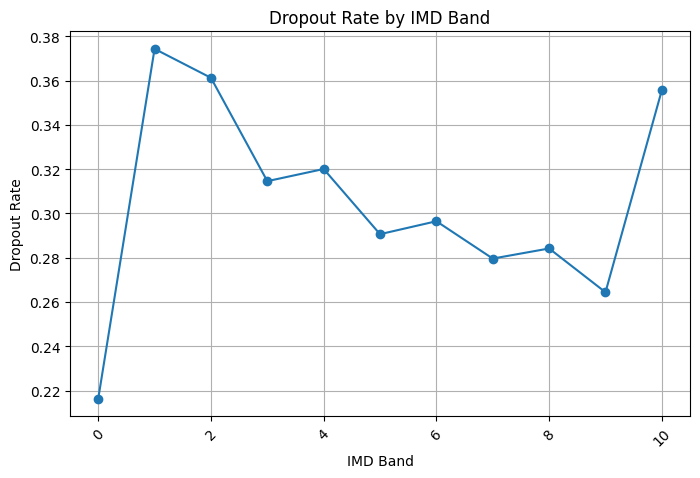

In [33]:
#  Dropout Rate by IMD Band
imd_dropout = df.groupby('imd_band')['target'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(imd_dropout['imd_band'], imd_dropout['target'], marker='o')
plt.title('Dropout Rate by IMD Band')
plt.xlabel('IMD Band')
plt.ylabel('Dropout Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_28696\304543567.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_dropout.values, y=region_dropout.index, palette='viridis')


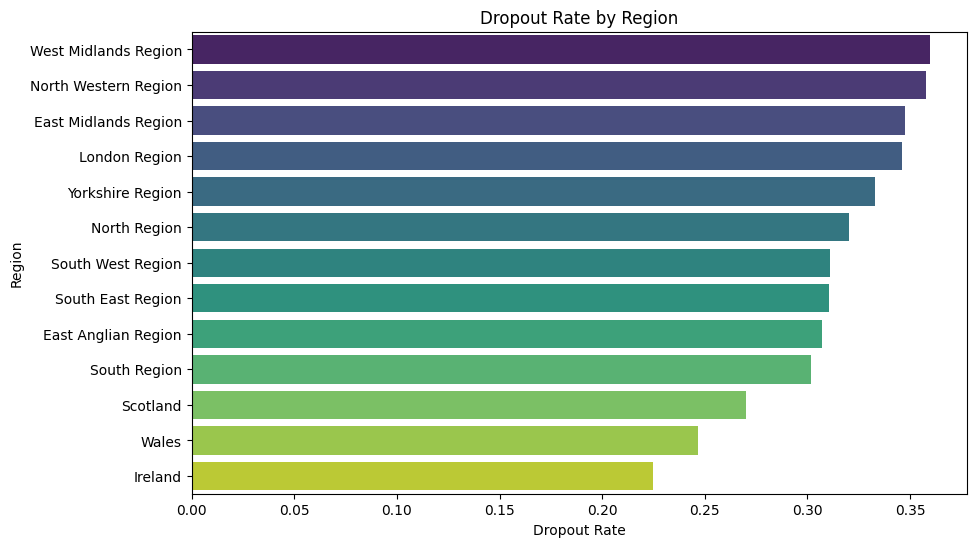

In [34]:
#  Dropout Rate by Region
region_dropout = df.groupby('region')['target'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=region_dropout.values, y=region_dropout.index, palette='viridis')
plt.title('Dropout Rate by Region')
plt.xlabel('Dropout Rate')
plt.ylabel('Region')
plt.show()

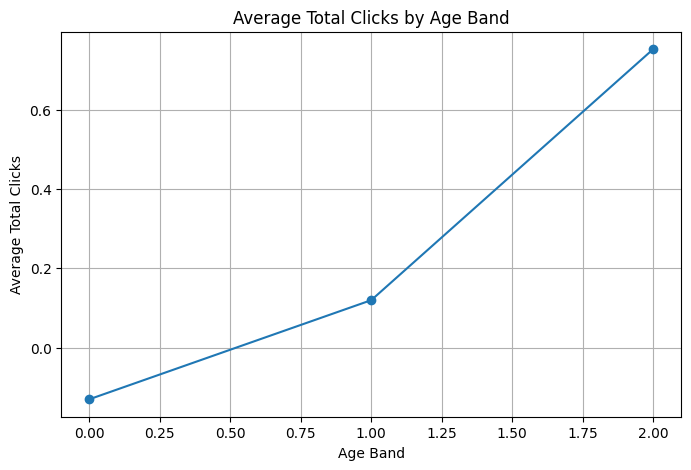

In [35]:
#  Average Total Clicks by Age Band
clicks_by_age = df.groupby('age_band')['total_clicks'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(clicks_by_age['age_band'], clicks_by_age['total_clicks'], marker='o')
plt.title('Average Total Clicks by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Average Total Clicks')
plt.grid(True)
plt.show()

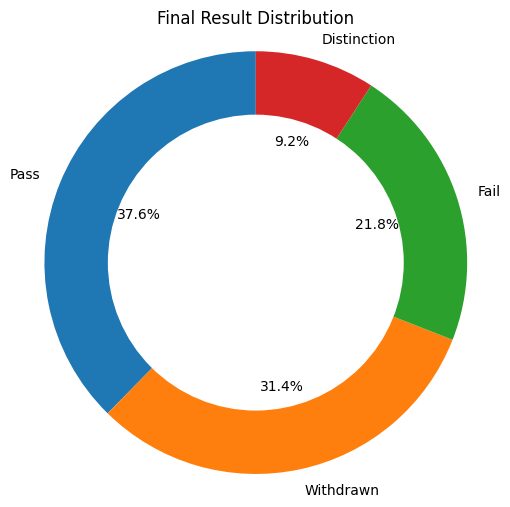

In [36]:
# Final Result Distribution
final_counts = df['final_result'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.title('Final Result Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()